# **importing libraries**

In [ ]:
import numpy as np
import csv
import random
from PIL import Image
from PIL import ImageShow
import scipy
import os
import tensorflow as tf
#import tensorflow.keras.backend.tensorflow_backend as KTF
from keras.layers import Input, Dense, Flatten, Activation,\
    BatchNormalization, Reshape, UpSampling2D, ZeroPadding2D, \
    Dropout, Lambda, AveragePooling2D, GlobalAveragePooling2D, concatenate
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras import Model
from keras.optimizers import Adam
from keras.applications.inception_v3 import InceptionV3
from keras.callbacks import ModelCheckpoint, History, EarlyStopping, CSVLogger, RemoteMonitor,ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
import pandas as pd
from random import randint
from skimage.transform import resize
from keras.applications.inception_v3 import preprocess_input
#from keras.applications.vgg16 import VGG16

#*getting data from kaggle and unziping it*

In [ ]:
# Getting the api josn file to download the data from kaggle (competition authorization)
from google.colab import files
#files.upload()

!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json  # set permission

kaggle.json


In [ ]:
!kaggle datasets download -d kmader/rsna-bone-age

100% 9.28G/9.29G [02:25<00:00, 55.3MB/s]
100% 9.29G/9.29G [02:25<00:00, 68.6MB/s]


In [ ]:
!unzip -qq /content/rsna-bone-age.zip

#**preparing gender data and boneage (y) from csv**

In [ ]:
df_raw =pd.read_csv('/content/boneage-training-dataset.csv')

In [ ]:
df_raw

,id,boneage,male
0,1377,180,False
1,1378,12,False
2,1379,94,False
3,1380,120,True
4,1381,82,False
...,...,...,...
12606,15605,50,False
12607,15606,113,False
12608,15608,55,False
12609,15609,150,True


In [ ]:
print(df_raw.head(6))

     id  boneage   male
0  1377      180  False
1  1378       12  False
2  1379       94  False
3  1380      120   True
4  1381       82  False
5  1382      138   True


In [ ]:
print(df_raw['boneage'][5])

138


In [ ]:
import csv
from collections import defaultdict

In [ ]:
# seperarting every coloum in a seperated list 
id_train = []
boneage_train = []
male_train = []
with open('boneage-training-dataset.csv', 'r') as f:
    reader = csv.reader(f, delimiter=',')
    for row in reader:
        id_train.append(row[0])
        boneage_train.append(row[1])
        male_train.append(row[2])

In [ ]:
#removing every True value in male list and convert it 1 and false value to 0
for i in range (len(male_train)) :
  if male_train[i]=='True': male_train[i]=1
  else: male_train [i] = 0 


In [ ]:
#removing head titles from lists 
id_train.pop(0);male_train.pop(0);boneage_train.pop(0)

'boneage'

In [ ]:
import os
training_data_dir ='/content/boneage-training-dataset/boneage-training-dataset'
training_data_list = (os.listdir(training_data_dir)) #get training imgs names in a list 
training_data_list.sort() #when u get them in a list ,they r not sorted so u need to sort it 

#preparing evaluation data 

In [ ]:
os.mkdir('/content/valdation')
os.mkdir('/content/valdation/val_img')
#os.mkdir('/content/valdation/val_labels')

In [ ]:
import shutil
for val in range (1200):
  shutil.move(f'/content/boneage-training-dataset/boneage-training-dataset/{training_data_list[val]}','/content/valdation/val_img')

In [ ]:
validation_list= os.listdir('/content/valdation/val_img')
print(len(validation_list))

1200


In [ ]:
#preparing evaluation lists for every coloum
id_val=[]
male_val=[]
boneage_val=[]
for i in range (1200):
  id_val.append( id_train[i]) 
  male_val.append(male_train[i])
  boneage_val.append(boneage_train[i])


In [ ]:
print(len(id_val))
print(len(boneage_val))
print(len(male_val))

1200
1200
1200


In [ ]:
for i in range (7) :
  print(id_val[i],'\t',male_val[i],'\t',boneage_val[i])


1377 	 0 	 180
1378 	 0 	 12
1379 	 0 	 94
1380 	 1 	 120
1381 	 0 	 82
1382 	 1 	 138
1383 	 1 	 150


In [ ]:
del id_train[0:1200]
del boneage_train[0:1200]
del male_train[0:1200]

In [ ]:
print(len(training_data_list))
print(len(id_train))

12611
11411


In [ ]:
print(len(boneage_train))

11411


In [ ]:
for i in range (6):
  print (male_train[i])

0
0
1
1
1
0


In [ ]:
print(len(id_train))

11411


In [ ]:

boneage_train = np.array(np.reshape(boneage_train,(-1,)), dtype='float32')
male_train = np.array(np.reshape(male_train,(-1,)), dtype='float32')

boneage_val = np.array(np.reshape(boneage_val,(-1,)), dtype='float32')
male_val = np.array(np.reshape(male_val,(-1,)), dtype='float32')

In [ ]:
print((male_train).shape)

(11411,)


In [ ]:
import matplotlib.pyplot as plt

Text(0, 0.5, 'gender_type')

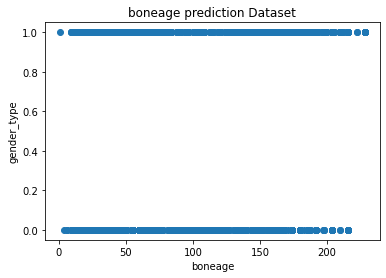

In [ ]:
# create a figure and axis
fig, ax = plt.subplots()

# scatter the boneage against the gender_type
ax.scatter(df_raw['boneage'], df_raw['male'])
# set a title and labels
ax.set_title('boneage prediction Dataset')
ax.set_xlabel('boneage')
ax.set_ylabel('gender_type')

#how images data looks like ?

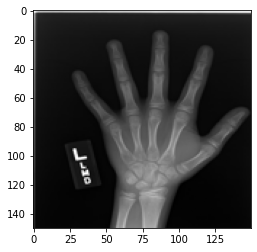

In [ ]:
#this how the original data looks like 
img_name= ('/content/boneage-training-dataset/boneage-training-dataset/11356.png')
img = Image.open(img_name).convert('RGB')#data is greyscale so we need to convert it to RGB because the model (inception v3) input is 3 channels
img = np.array(img.resize((150,150))) 
img = img.reshape( img.shape[0], img.shape[1],img.shape[2])
#img = preprocess_input(img)

#img= (np.array(np.reshape(img, (-1, 150, 150, 3)), dtype='float32')/255.0)-0.5
img=(np.array(img,dtype='float32')/255)
#img=(np.array(img,dtype='float32'))
imgplot = plt.imshow(img)


Populating the interactive namespace from numpy and matplotlib


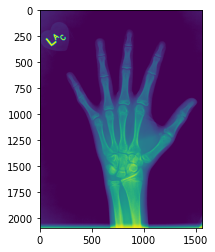

In [ ]:
#this how the data looks like with zero green channel
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
for i in range (4) : 
  value = random.randint(0,500)
  img = mpimg.imread(f'/content/boneage-training-dataset/boneage-training-dataset/{training_data_list[value]}')
  #lum_img = img[:, :, 0]
  imgplot = plt.imshow(img)


#**processing image data to get it ready for training**

In [ ]:
# for training data 

from skimage.transform import resize
from keras.applications.inception_v3 import preprocess_input

img_size=150 # this is the size which fits in ram size 
training_data = []

training_data_dir ='/content/boneage-training-dataset/boneage-training-dataset'
training_data_list = (os.listdir(training_data_dir)) #get training imgs names in a list 
training_data_list.sort() #when u get them in a list ,they r not sorted so u need to sort it 


for i in range(len(id_train)):
        img_name = f'/content/boneage-training-dataset/boneage-training-dataset/{training_data_list[i]}'
        img = Image.open(img_name).convert('RGB')#data is greyscale so we need to convert it to RGB because the model (inception v3) input is 3 channels
        img = np.array(img.resize((img_size,img_size)))
        img = img.reshape( img.shape[0], img.shape[1],img.shape[2])
        #img = preprocess_input(img)
        training_data.append(img)

training_data = np.array(np.reshape(training_data, (-1, 150, 150, 3)), dtype='float32')/255.0
#training_data = (np.array(np.reshape(training_data, (-1, 299, 299, 3)), dtype='float32')/255.0)-0.5

[[[0.13333334 0.13333334 0.13333334]
  [0.12941177 0.12941177 0.12941177]
  [0.12941177 0.12941177 0.12941177]
  ...
  [0.13725491 0.13725491 0.13725491]
  [0.13725491 0.13725491 0.13725491]
  [0.14509805 0.14509805 0.14509805]]

 [[0.12941177 0.12941177 0.12941177]
  [0.1254902  0.1254902  0.1254902 ]
  [0.1254902  0.1254902  0.1254902 ]
  ...
  [0.13333334 0.13333334 0.13333334]
  [0.13333334 0.13333334 0.13333334]
  [0.14117648 0.14117648 0.14117648]]

 [[0.1254902  0.1254902  0.1254902 ]
  [0.12156863 0.12156863 0.12156863]
  [0.12156863 0.12156863 0.12156863]
  ...
  [0.12941177 0.12941177 0.12941177]
  [0.13333334 0.13333334 0.13333334]
  [0.14117648 0.14117648 0.14117648]]

 ...

 [[0.02352941 0.02352941 0.02352941]
  [0.02352941 0.02352941 0.02352941]
  [0.02352941 0.02352941 0.02352941]
  ...
  [0.03529412 0.03529412 0.03529412]
  [0.03921569 0.03921569 0.03921569]
  [0.04313726 0.04313726 0.04313726]]

 [[0.02352941 0.02352941 0.02352941]
  [0.02352941 0.02352941 0.02352941]


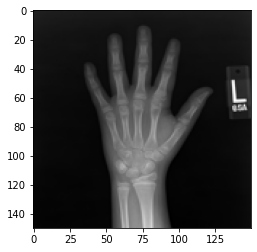

In [ ]:
#this is how the data looks like after our processing 
img_namee=training_data[50]
print(img_namee)
imgplot = plt.imshow(img_namee)

In [ ]:
training_data[0].shape

(150, 150, 3)

In [ ]:
len(training_data)

11411

In [ ]:
#saving resulted array from processing into csv to be easy to reload
np.save(f'/content/drive/My Drive/Projects/bone_age_prediction/images_in_np_array_to_csv/training_{training_size}', training_data)

In [ ]:
#loading it 
training_data = np.load(f'/content/drive/My Drive/Projects/bone_age_prediction/images_in_np_array_to_csv/training_{training_size}')

In [ ]:
#doing the same processing for validation data 
from keras.applications.inception_v3 import preprocess_input
img_size=150
validation_data = []

validation_data_dir ='/content/valdation/val_img'
validation_data_list = (os.listdir(validation_data_dir))
validation_data_list.sort()

for i in range(len(id_val)):
        img_name = f'/content/valdation/val_img/{validation_data_list[i]}'
        img = Image.open(img_name).convert('RGB')
        img = np.array(img.resize((img_size,img_size)))
        img = img.reshape((img.shape[0], img.shape[1],img.shape[2]))
        #img = preprocess_input(img)
        validation_data.append(img)

validation_data = np.array(np.reshape(validation_data, (-1, 150, 150, 3)), dtype='float32')/255.0
#validation_data = (np.array(np.reshape(validation_data, (-1, 299, 299, 3)), dtype='float32')/255.0)-0.5

In [ ]:
np.save('/content/drive/My Drive/Projects/bone_age_prediction/images_in_np_array_to_csv/validation_data', validation_data)

In [ ]:
validation_data = np.load('/content/drive/My Drive/Projects/bone_age_prediction/images_in_np_array_to_csv/validation_data')

In [ ]:
validation_data[0].shape

(150, 150, 3)

In [ ]:
len(validation_data)

1200

#**working on model with two inputs (gender and image data)**

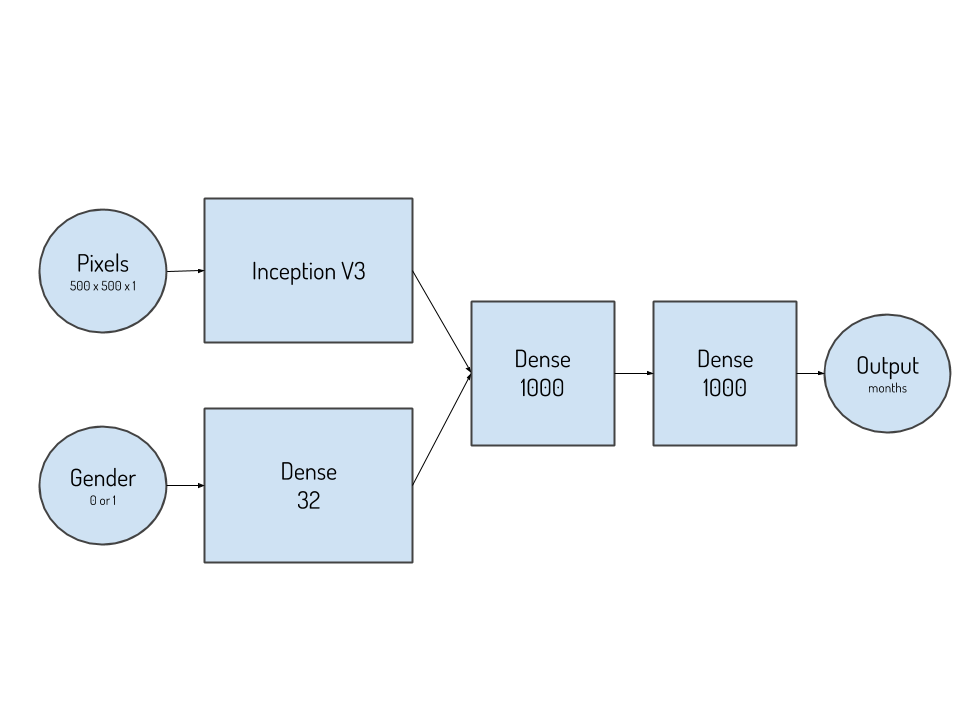

In [ ]:
i1 = Input(shape=(150,150,3), name='input_img')
i2 = Input(shape=(1,), name='input_gender')
base_model = InceptionV3(input_tensor=i1, input_shape=(150, 150, 3), include_top=False, weights=None)
feature_image = base_model.output
feature_image = GlobalAveragePooling2D()(feature_image)
feature_image = Flatten()(feature_image)
feature_gender = Dense (32,activation='relu') (i2)
feature = concatenate([feature_image, feature_gender], axis=1)
o = Dense ( 1000, activation='relu') (feature)
o = Dense (1000,activation='relu') (o)
o = Dense(1,activation='relu')(o)

model = Model(inputs=[i1,i2],outputs=o) 
optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(loss='mean_absolute_error',optimizer=optimizer,metrics = ['accuracy'] )


In [ ]:
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_img (InputLayer)          [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d_188 (Conv2D)             (None, 74, 74, 32)   864         input_img[0][0]                  
__________________________________________________________________________________________________
batch_normalization_188 (BatchN (None, 74, 74, 32)   96          conv2d_188[0][0]                 
__________________________________________________________________________________________________
activation_188 (Activation)     (None, 74, 74, 32)   0           batch_normalization_188[0][0]    
_______________________________________________________________________________________

In [ ]:
train_idg = ImageDataGenerator(rotation_range=20, width_shift_range=0.2, height_shift_range=0.2,
                              zoom_range=0.2, horizontal_flip=True,validation_split=0.1)

val_idg = ImageDataGenerator(width_shift_range=0.25, height_shift_range=0.25, horizontal_flip=True)




In [ ]:
batch_size=16
train_generator = train_idg.flow(
        training_data,
        boneage_train,
        batch_size=batch_size)


validation_generator = val_idg.flow(
                                validation_data,
                                boneage_val,
                                batch_size=batch_size
                                )
#save_to_dir='/content/augemented'

In [ ]:
#combining the two generators for gender and image data 
from itertools import cycle


def combined_generators(image_generator, gender_data, batch_size):
    gender_generator = cycle(batch(gender_data, batch_size))
    while True:
        nextImage = next(image_generator)
        nextGender = next(gender_generator)
        assert len(nextImage[0]) == len(nextGender)
        yield [nextImage[0], nextGender], nextImage[1]

def batch(iterable, n=1):
    l = len(iterable)
    for ndx in range(0, l, n):
        yield iterable[ndx:min(ndx + n, l)]



In [ ]:
train_gen_wrapper = combined_generators(train_generator, male_train, batch_size)
val_gen_wrapper = combined_generators(validation_generator, male_val, batch_size)

In [ ]:
#history = History()
logger = CSVLogger('/content/drive/My Drive/Projects/bone_age_prediction/logs/training.log', separator=',', append=False)
earlystopping = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=10, verbose=10, mode='min')
checkpoint = ModelCheckpoint('/content/drive/My Drive/Projects/bone_age_prediction/checkpoint '+ 'weights-{epoch:02d}-{val_loss:.2f}.h5', monitor='val_loss', save_best_only=True, verbose=1, mode='min')
reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=10, verbose=1, mode='auto', min_delta=0.0001, cooldown=5, min_lr=0.0001)

In [ ]:
NUM_EPOCHS=100

history = model.fit_generator(train_gen_wrapper, validation_data=val_gen_wrapper,
                              epochs=NUM_EPOCHS, steps_per_epoch=len(train_generator),
                              validation_steps=len(validation_generator),
                              callbacks=[ early, checkpoint, reduceLROnPlat])

#**working with model takes one input (image data )**






In [ ]:
#building the model
def Boneage_prediction_model():
    i1 = Input(shape=(150,150,3), name='input_img')
    base = InceptionV3(input_tensor=i1, input_shape=(150,150,3), include_top=False, weights='imagenet')
    feature_img = base.get_layer(name='mixed10').output
    feature_img = AveragePooling2D((2,2))(feature_img)
    feature_img = Flatten()(feature_img)
    feature = feature_img
    o = Dense(1000, activation='relu')(feature)
    o = Dense(1000, activation='relu')(o)
    o = Dense(1)(o)
    model = Model(inputs=i1, outputs=o)
    optimizer =Adam(lr=1e-3)
    model.compile(loss='mean_absolute_error', optimizer=optimizer, metrics=['mae'])
    return model

In [ ]:
model = Boneage_prediction_model()
history = History()

In [ ]:
model.summary()

Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_img (InputLayer)          [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d_376 (Conv2D)             (None, 74, 74, 32)   864         input_img[0][0]                  
__________________________________________________________________________________________________
batch_normalization_376 (BatchN (None, 74, 74, 32)   96          conv2d_376[0][0]                 
__________________________________________________________________________________________________
activation_376 (Activation)     (None, 74, 74, 32)   0           batch_normalization_376[0][0]    
_______________________________________________________________________________________

##**data augmantation**



In [ ]:
datagen = ImageDataGenerator(  # 1
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=False)
datagen.fit(training_data)

Populating the interactive namespace from numpy and matplotlib


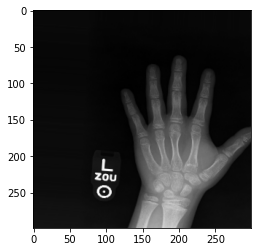

In [ ]:
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img = mpimg.imread('/content/augmented/_10129_3047768.png')
imgplot = plt.imshow(img)


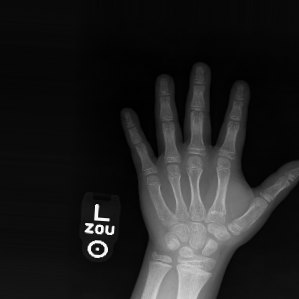

In [ ]:
img = Image.open('/content/augmented/_10129_3047768.png')
img

##training the model



In [ ]:
#callbacks
history = History()
logger = CSVLogger('/content/drive/My Drive/Projects/bone_age_prediction/logs/training.log', separator=',', append=False)
earlystopping = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=10, verbose=10, mode='min')
checkpoint = ModelCheckpoint('/content/drive/My Drive/Projects/bone_age_prediction/checkpoint '+ 'weights-{epoch:02d}-{val_loss:.2f}.h5', monitor='val_loss', save_best_only=True, verbose=1, mode='min')
reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=10, verbose=1, mode='auto', min_delta=0.0001, cooldown=5, min_lr=0.0001)

In [ ]:
model.fit_generator(datagen.flow(training_data, boneage_train, batch_size=16),
                    steps_per_epoch = 600,
                    epochs=100,
                    callbacks=[history, logger, checkpoint, reduceLROnPlat],
                    validation_data=(validation_data, boneage_val),
                    verbose=1)

Epoch 1/100
600/600 [==============================] - ETA: 0s - loss: 36.1970 - mae: 36.1970
Epoch 00001: val_loss improved from inf to 76.62642, saving model to /content/drive/My Drive/Projects/bone_age_prediction/checkpoint weights-01-76.63.h5
600/600 [==============================] - 67s 111ms/step - loss: 36.1970 - mae: 36.1970 - val_loss: 76.6264 - val_mae: 76.6264
Epoch 2/100
600/600 [==============================] - ETA: 0s - loss: 33.5738 - mae: 33.5738
Epoch 00002: val_loss improved from 76.62642 to 39.79188, saving model to /content/drive/My Drive/Projects/bone_age_prediction/checkpoint weights-02-39.79.h5
600/600 [==============================] - 66s 110ms/step - loss: 33.5738 - mae: 33.5738 - val_loss: 39.7919 - val_mae: 39.7919
Epoch 3/100
600/600 [==============================] - ETA: 0s - loss: 33.6861 - mae: 33.6861
Epoch 00003: val_loss did not improve from 39.79188
600/600 [==============================] - 63s 105ms/step - loss: 33.6861 - mae: 33.6861 - val_loss

#evaluation

Text(0.5, 1.0, 'Training and validation loss')

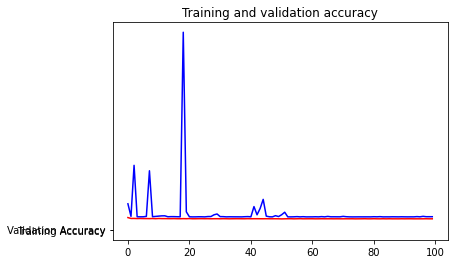

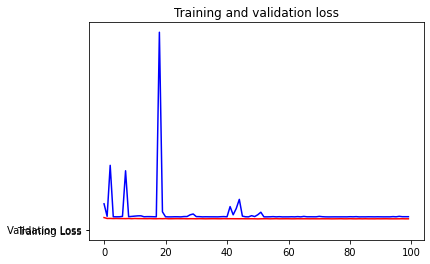

In [ ]:
# PLOT LOSS AND ACCURACY
%matplotlib inline

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['mae']
val_acc=history.history['val_mae']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")


plt.title('Training and validation loss')

# Desired output. Charts with training and validation metrics. No crash :)

#loading checkpiont and predicting

In [ ]:
checkpoint_path = "/content/drive/My Drive/Projects/bone_age_prediction/checkpoint weights-07-38.19.h5"
model.load_weights(checkpoint_path)

In [ ]:
img_name = f'/content/valdation/val_img/{validation_data_list[200]}'
img = Image.open(img_name).convert('RGB')
img = np.array(img.resize((150,150)))
img = img.reshape( img.shape[0], img.shape[1],img.shape[2])
img = np.array(np.reshape(img, (-1, 150, 150, 3)), dtype='float32')/255.0

In [ ]:
pred= model.predict(img)
print(pred)
print(boneage_val[200])

[[130.53416]]
162.0
